# Recommendation system

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import style
from sklearn import preprocessing
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import *
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix
import math as mth
#style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [26]:
user_df =pd.read_csv('kaggle_visible_evaluation_triplets.txt',sep='\t',names=['user_id', 'song_id', 'freq'])
song_df = pd.read_csv('unique_tracks.txt', sep = '<SEP>', names = ['track_id', 'song_id', 'artist_name', 'Title'])

# EDA

In [27]:
user_df.head()

,user_id,song_id,freq
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1


In [28]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450933 entries, 0 to 1450932
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   user_id  1450933 non-null  object
 1   song_id  1450933 non-null  object
 2   freq     1450933 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 33.2+ MB


In [29]:
user_df.describe()

,freq
count,1.450933e+06
mean,3.187149e+00
std,7.051664e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,9.230000e+02


In [30]:
len(user_df['user_id'].unique())

110000

In [31]:
len(user_df['song_id'].unique())

163206

In [32]:
song_df.head()

,track_id,song_id,artist_name,Title
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos QuerÃ©s
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [33]:
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   track_id     1000000 non-null  object
 1   song_id      1000000 non-null  object
 2   artist_name  1000000 non-null  object
 3   Title        999985 non-null   object
dtypes: object(4)
memory usage: 30.5+ MB


In [34]:
sum(song_df['song_id'].duplicated())

944

In [35]:
len(song_df['song_id'].unique())

999056

There are 944 duplicates in the song info dataframe

For Example : 

In [36]:
song_df[song_df['song_id']=='SOJHKXX12A8C139798']

,track_id,song_id,artist_name,Title
5354,TRMHUEV12903CB0E5C,SOJHKXX12A8C139798,Incubus,A Crow Left Of The Murder
32760,TRMDYQQ128F428080C,SOJHKXX12A8C139798,Incubus,A Crow Left Of The Murder


The duplicates has different track_id for the same songs

In [37]:
user_df.isna().sum()

user_id    0
song_id    0
freq       0
dtype: int64

In [38]:
song_df.isna().sum()

track_id        0
song_id         0
artist_name     0
Title          15
dtype: int64

There are 15 null values in song info dataframe

In [39]:
song_df[song_df['Title'].isna()]

,track_id,song_id,artist_name,Title
64262,TRWEQAA128EF36407B,SOVICLT12A58A7C4D0,Milton,NaN
114672,TRGYSOE12903CDCA99,SOAGRAA12AB018D567,SÃ©bastien Roch,NaN
229353,TRRYWZX12903CDCAD0,SOOAFJX12AB018A028,SÃ©bastien Roch,NaN
264639,TRBXMXG12903CDCA7F,SOLDTFD12AB018AFE6,SÃ©bastien Roch,NaN
458083,TRAXBZR12903CDCA82,SOAUTVB12AB018AFF0,SÃ©bastien Roch,NaN
557125,TRTNWIY12903CDCA7C,SOMPGYE12AB018AFE0,SÃ©bastien Roch,NaN
578241,TRUMISC12903CDCAB3,SOVHAZH12AB018D5B3,SÃ©bastien Roch,NaN
652287,TRLKLLK12903CDCAA2,SOECGBQ12AB018D582,SÃ©bastien Roch,NaN
697789,TRJHIKS12903CDCAAD,SOTJWHR12AB018D5A0,SÃ©bastien Roch,NaN
697813,TRJHIYF12903CB7FCF,SOBDDHR12AB01888A6,Remute,NaN


The na values are present in Title

In [17]:
user_df[user_df['song_id']=='SOAGRAA12AB018D567']

,user_id,song_id,freq


But these song id are not present in the user dataframe

In [18]:
song_df.shape

(1000000, 4)

In [19]:
song_df.dropna(inplace=True)

In [20]:
song_df.shape

(999985, 4)

In [21]:
user_df.shape

(1450933, 3)

In [24]:
users = new_df['user_id'].unique()
len(users)

110000

There are 110000 users in the data

In [ ]:
len(new_df['song_id'].duplicated())

In [ ]:
len(new_df['song_id'].unique())

There are 163206 songs 

In [40]:
new_df = pd.merge(user_df,song_df.drop_duplicates(['song_id']), on="song_id", how="left")


In [41]:
new_df.head()

,user_id,song_id,freq,track_id,artist_name,Title
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,TRTNDNE128F1486812,Cartola,Tive Sim
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,TRASTUE128F930D488,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,TRFPLWO128F1486B9E,Miguel Calo,El Cuatrero


A list of users with their song that they have listened to

In [42]:
len(new_df['user_id'].unique())

110000

In [43]:
len(new_df['song_id'].unique())

163206

In [44]:
new_df.isnull().sum()

user_id        0
song_id        0
freq           0
track_id       0
artist_name    0
Title          1
dtype: int64

In [45]:
new_df[new_df['Title'].isna()]

,user_id,song_id,freq,track_id,artist_name,Title
192828,7b3a62a418862aefc4b3d85feb191fa0fd752c69,SOZDBDL12AB018AFFF,1,TROFVVS12903CDCA87,SÃ©bastien Roch,NaN


In [46]:
new_df.dropna(inplace=True)

In [47]:
new_df.describe()

,freq
count,1.450932e+06
mean,3.187151e+00
std,7.051666e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,9.230000e+02


In [48]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450932 entries, 0 to 1450932
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1450932 non-null  object
 1   song_id      1450932 non-null  object
 2   freq         1450932 non-null  int64 
 3   track_id     1450932 non-null  object
 4   artist_name  1450932 non-null  object
 5   Title        1450932 non-null  object
dtypes: int64(1), object(5)
memory usage: 77.5+ MB


In [49]:
new_df['freq'].max()

923

In [50]:
new_df['freq'].min()

1

In [51]:
new_df[new_df['freq']==923]

,user_id,song_id,freq,track_id,artist_name,Title
1449167,22bb29714137fa47083963c30e1a26f1bf517e7d,SOXTUWG12AB018A2E2,923,TRXIHSR12903CC4FA5,Kilgore,Drop The Hammer (Album Version)


A user '22bb29714137fa47083963c30e1a26f1bf517e7d' has listened to the above song 923 times

In [52]:
new_df['song'] = new_df["artist_name"] + ' - ' + new_df["Title"]
song_grouped = new_df.groupby(['song']).agg({'freq':'count'}).reset_index()
grouped_sum = song_grouped['freq'].sum()
song_grouped['percentage']  = song_grouped['freq'].div(grouped_sum)*100
song_grouped.sort_values(['freq', 'song'], ascending = False,inplace=True)
song_grouped.rename(columns={'freq':'popularity'},inplace=True)

In [53]:
song_grouped

,song,popularity,percentage
59878,Harmonia - Sehr kosmisch,5043,0.347570
17175,BjÃ¶rk - Undo,4483,0.308974
42714,Dwight Yoakam - You're The One,4136,0.285058
51326,Florence + The Machine - Dog Days Are Over (Ra...,3780,0.260522
77664,Kings Of Leon - Revelry,3672,0.253079
...,...,...,...
15,'68 Comeback - A Long Time Ago,1,0.000069
14,'68 Comeback - A Little Bitch (And A Little Bi...,1,0.000069
13,& And Oceans - Odious And Devious,1,0.000069
12,& And Oceans - Aphelion: Light Evanescence: In...,1,0.000069


The most popular song is Sehr kosmisch by Harmonia heard by almost 35% of the people 

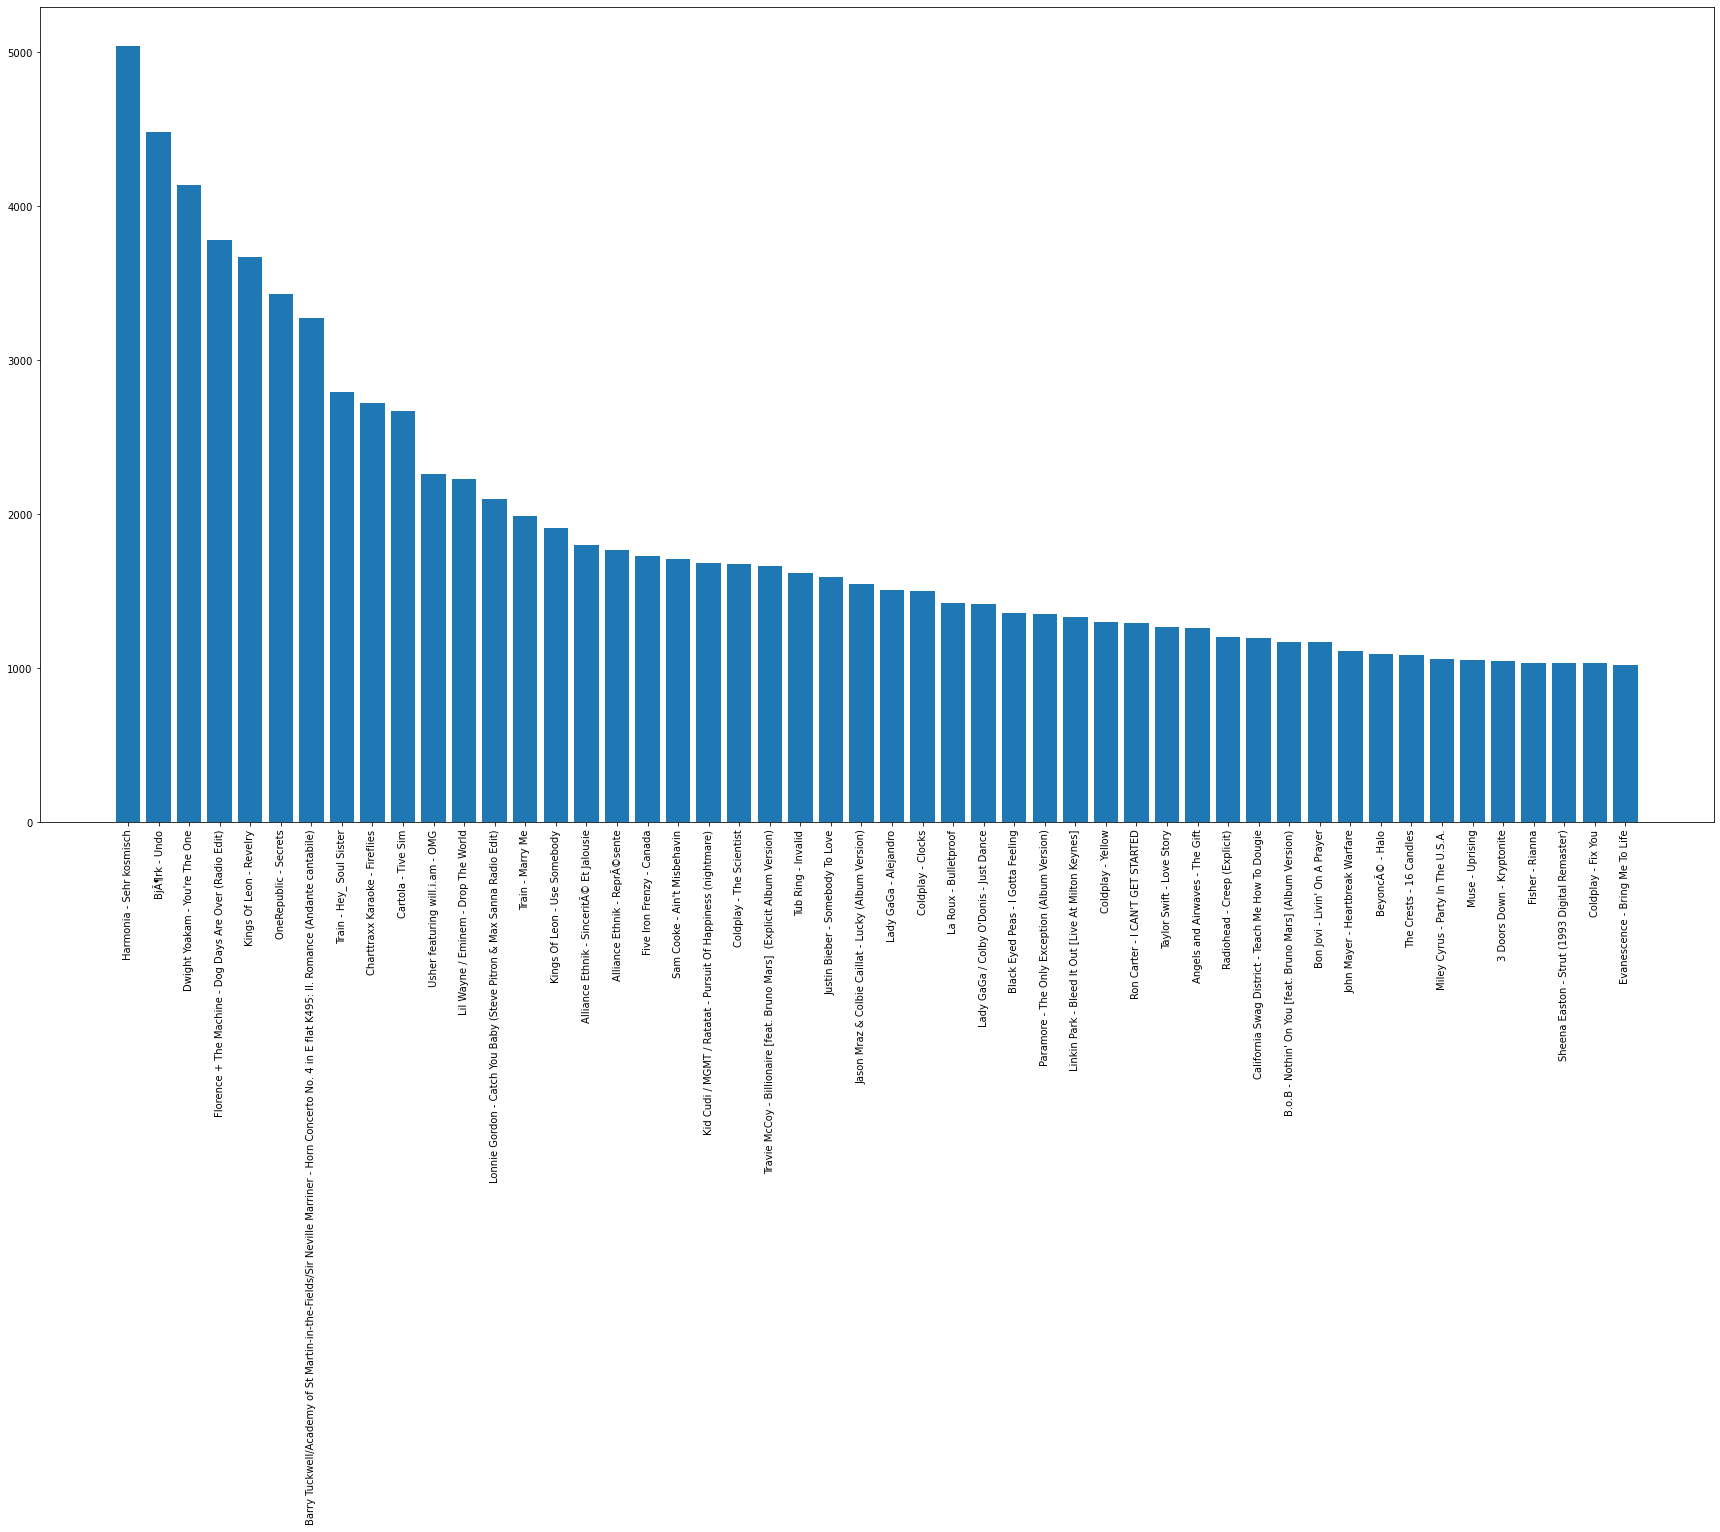

In [54]:
plt.figure(figsize=(30,15))
plt.bar(x=song_grouped['song'][:50],height=song_grouped['popularity'][:50])
plt.xticks(range(len(song_grouped['song'][:50])), song_grouped['song'][:50], rotation='vertical')
plt.show()

In [55]:
popular_artists = new_df.groupby(['artist_name']).agg({'song_id':'count'}).reset_index().sort_values('song_id',ascending=False)
popular_artists.rename(columns={'song_id':'popular'},inplace=True)

In [56]:
popular_artists.head(10)

,artist_name,popular
5085,Coldplay,12279
13610,Kings Of Leon,8514
8801,Florence + The Machine,8213
12964,Justin Bieber,7669
11378,Jack Johnson,6784
26440,Train,6617
23945,The Black Keys,6507
7969,Eminem,6297
18346,OneRepublic,6027
17317,Muse,5849


### Coldplay hits the top in the poularity list!

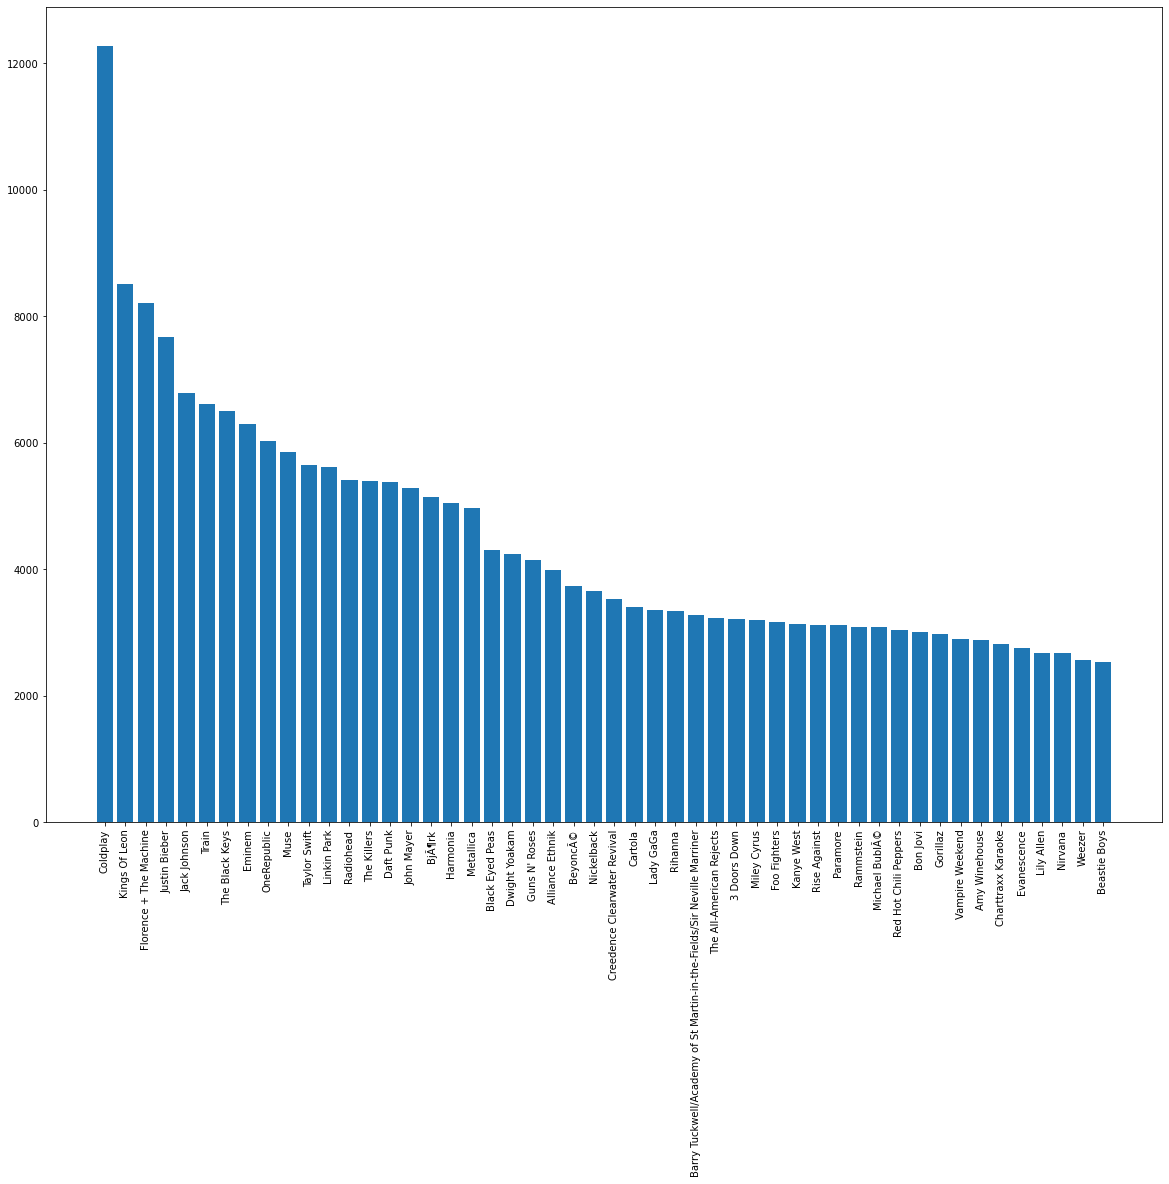

In [57]:
plt.figure(figsize=(20,15))
plt.bar(popular_artists['artist_name'][:50],popular_artists['popular'][:50])
plt.xticks(range(len(popular_artists['artist_name'][:50])), popular_artists['artist_name'][:50], rotation='vertical')
plt.show()

In [69]:
c=new_df[new_df['artist_name']=='Coldplay']
coldplay_top = c.groupby(['Title']).agg({'song_id':'count'}).reset_index().sort_values('song_id',ascending=False)

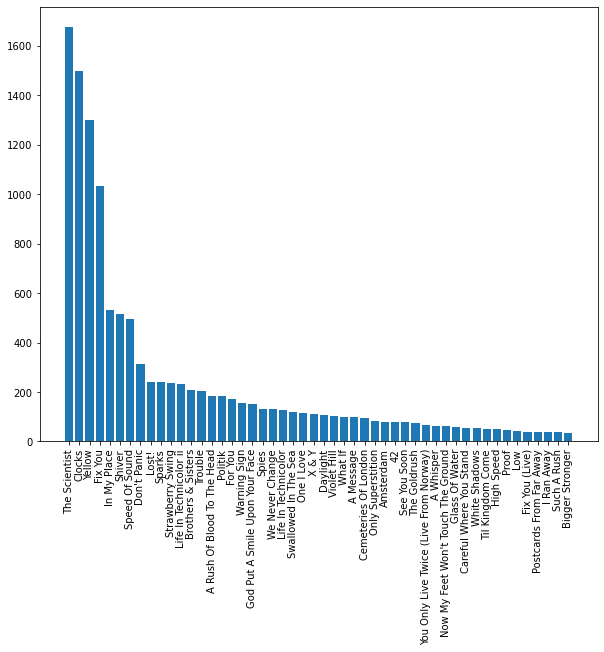

In [70]:
plt.figure(figsize=(10,8))
plt.bar(coldplay_top['Title'][:50],coldplay_top['song_id'][:50])
plt.xticks(range(len(coldplay_top['Title'][:50])), coldplay_top['Title'][:50], rotation='vertical')

plt.show()

The above plot show the top hits by coldplay and The scientist is in the first place

In [71]:
#checking the top coldplay listeners
top_coldplay_listeners=c.groupby(['user_id']).agg({'song_id':'count'}).reset_index().sort_values('song_id',ascending=False)

In [72]:
top_coldplay_listeners

,user_id,song_id
5399,c0cd5d98e8e91ad077cb28c1a9e42353c09fa4d3,26
152,05b58635a4a5973b44713fcd8eb6068938f6325a,25
6835,f78f852dd15c83e1b892762532997526afb9f15e,24
6230,e02bc9a0ad4fd9c270e0197e00b5ff8c3088d62a,21
2033,4a11e7866e7d5dcb42f2c494392783902f505aba,21
...,...,...
2801,648b8921ed7caf8057b85a4a775ab14558010bd0,1
2800,648b69f4e51e231191be385b1721726d25faa1f2,1
2799,648597db50a118eb180edd568cc35de7a80ee38c,1
2793,646034781f1a12909b702128f857f695bff7cf8b,1


The user 'c0cd5d98e8e91ad077cb28c1a9e42353c09fa4d3' has listened to 26 different songs of coldplay

In [73]:
user=np.array(top_coldplay_listeners['user_id'][:5])

In [74]:
a=new_df[new_df['user_id'].isin(user)]

In [75]:
b=a[a['artist_name']!='Coldplay']

In [76]:
b

,user_id,song_id,freq,track_id,artist_name,Title,song
191257,4a11e7866e7d5dcb42f2c494392783902f505aba,SOJJDYI12A6701FC23,2,TRIIIKY128E078FC2F,Jack Johnson,Holes To Heaven,Jack Johnson - Holes To Heaven
191264,4a11e7866e7d5dcb42f2c494392783902f505aba,SOKXYUW12A8C140229,1,TRAYQLP128F92FA224,BeyoncÃ© feat. Slim Thug,Check On It,BeyoncÃ© feat. Slim Thug - Check On It
191272,4a11e7866e7d5dcb42f2c494392783902f505aba,SOIXKRK12A8C140BD1,1,TRQRSAK128F429DE8C,The Killers,Who Let You Go?,The Killers - Who Let You Go?
191275,4a11e7866e7d5dcb42f2c494392783902f505aba,SOKUECJ12A6D4F6129,2,TRKNVRW128F9309A57,The Killers,Somebody Told Me,The Killers - Somebody Told Me
191277,4a11e7866e7d5dcb42f2c494392783902f505aba,SODWUBY12A6D4F8E8A,1,TRMEBVU128F92F64DB,Amy Winehouse,Some Unholy War,Amy Winehouse - Some Unholy War
685209,c0cd5d98e8e91ad077cb28c1a9e42353c09fa4d3,SOQWYAQ12A6D4FB9A3,1,TRHPTMT128F92F28D1,Rihanna,Take A Bow,Rihanna - Take A Bow
685221,c0cd5d98e8e91ad077cb28c1a9e42353c09fa4d3,SOVDLZN12AB0185BEA,1,TRDTWWZ12903CC36D8,The Black Keys,Tighten Up,The Black Keys - Tighten Up
685226,c0cd5d98e8e91ad077cb28c1a9e42353c09fa4d3,SORIJHN12AB018C4D0,2,TRDTIZT12903CC55CC,Michael BublÃ©,Mack The Knife (Album Version),Michael BublÃ© - Mack The Knife (Album Version)
685228,c0cd5d98e8e91ad077cb28c1a9e42353c09fa4d3,SOSVQNK12AC468D6BE,1,TRIDQJA12903CE29CC,Deadmau5,Moar Ghosts 'n' Stuff,Deadmau5 - Moar Ghosts 'n' Stuff
685230,c0cd5d98e8e91ad077cb28c1a9e42353c09fa4d3,SOFRQTD12A81C233C0,1,TRDMBIJ128F4290431,Harmonia,Sehr kosmisch,Harmonia - Sehr kosmisch


The above list shows the songs heard by the top 5 coldplay listeners

In [77]:
#top metallica listeners
m=new_df[new_df['artist_name']=='Metallica']
top_metallica_listeners=m.groupby(['user_id']).agg({'song_id':'count'}).reset_index().sort_values('song_id',ascending=False)

In [78]:
m_user=np.array(top_metallica_listeners['user_id'][:5])
m_user=new_df[new_df['user_id'].isin(m_user)]
other_metallica_user=m_user[m_user['artist_name']!='Metallica']

In [79]:
top_metallica_listeners

,user_id,song_id
1544,6bfd2c692f8f5e3a74a97c7254e4b615a0ea9fdb,14
1309,5bec3bd272263e0ba0993d021783efd606be12b6,12
206,0dfb18120aeaf35c846bab400653e156ae7b2526,11
1066,49e14811aa360fc69d174a2461004e8ec1b2641f,11
3278,eacdcf3e696dff891ec8e0ef4602367dfafaaa7b,11
...,...,...
1342,5de814e461c2f115dd60cd5f777091ce085652ec,1
1343,5ded27ab5da77f46b6902412b41f5a4168c568eb,1
1344,5df2a05232ccdb926e86e746b256ea06abc54991,1
1345,5e0f3279807ab174fd64dd2a0142c8af897bc54c,1


The user '6bfd2c692f8f5e3a74a97c7254e4b615a0ea9fdb' has listened to 14 different songs of metallica

In [80]:
other_metallica_user

,user_id,song_id,freq,track_id,artist_name,Title,song
56913,5bec3bd272263e0ba0993d021783efd606be12b6,SOYIZSN12A6701E0BB,2,TRFXKPH128E0793B8E,Soundgarden,Burden In My Hand,Soundgarden - Burden In My Hand
56914,5bec3bd272263e0ba0993d021783efd606be12b6,SONQEYS12AF72AABC9,3,TRANKTK128E07921D9,Counting Crows,Mr. Jones,Counting Crows - Mr. Jones
56917,5bec3bd272263e0ba0993d021783efd606be12b6,SODHBNJ12AF72A22E7,2,TROJDLJ128E0793B90,Soundgarden,Applebite,Soundgarden - Applebite
56918,5bec3bd272263e0ba0993d021783efd606be12b6,SOFZSOK12A8C132326,3,TREHXAH128F423DC1E,Soundgarden,Nothing To Say (Album),Soundgarden - Nothing To Say (Album)
56919,5bec3bd272263e0ba0993d021783efd606be12b6,SOBPZTW12A58A773B3,1,TRUMSGN128E0781E93,Cracker,I'm A Little Rocket Ship,Cracker - I'm A Little Rocket Ship
...,...,...,...,...,...,...,...
1234479,6bfd2c692f8f5e3a74a97c7254e4b615a0ea9fdb,SOJNTKO12A6D4FE9BE,2,TRDLTEC128F4231000,Coal Chamber,Bradley (Album Version),Coal Chamber - Bradley (Album Version)
1234480,6bfd2c692f8f5e3a74a97c7254e4b615a0ea9fdb,SOIYXAD12A6D4F807A,1,TRXEEXD128F1488F1B,Air,Another Day,Air - Another Day
1234482,6bfd2c692f8f5e3a74a97c7254e4b615a0ea9fdb,SOSKKUE12AB0180108,1,TRWKUEJ128F92FD513,Air,All I Need,Air - All I Need
1234486,6bfd2c692f8f5e3a74a97c7254e4b615a0ea9fdb,SOITFCH12A6D4F9478,1,TRLZHSB128F4261650,Benny Benassi Presents The Biz,Satisfaction,Benny Benassi Presents The Biz - Satisfaction


The above list shows the songs listened by the top 5 metallica listeners

In [86]:
#top songs for each artist
def popular(artist):
    input1=new_df[new_df['artist_name']==artist]
    popular_song_artists = input1.groupby(['Title']).agg({'song_id':'count'}).reset_index().sort_values('song_id',ascending=False)
    popular_song_artists.rename(columns={'song_id':'popular','Title':'songs'},inplace=True)
    print( popular_song_artists.head(10))

In [87]:
popular(str(input()))

Linkin Park
                                   songs  popular
3   Bleed It Out [Live At Milton Keynes]     1330
21            In The End (Album Version)      770
48        What I've Done (Album Version)      526
6               Crawling (Album Version)      472
30            New Divide (Album Version)      375
32       One Step Closer (Album Version)      351
15              Given Up (Album Version)      205
43     Shadow Of The Day (Album Version)      158
4     Breaking The Habit (Album Version)      153
28                           My December      148


In [83]:
new_df.head()

,user_id,song_id,freq,track_id,artist_name,Title,song
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,Dwight Yoakam - You're The One
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,TRTNDNE128F1486812,Cartola,Tive Sim,Cartola - Tive Sim
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,TRASTUE128F930D488,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,Lonnie Gordon - Catch You Baby (Steve Pitron &...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,TRFPLWO128F1486B9E,Miguel Calo,El Cuatrero,Miguel Calo - El Cuatrero


# Item based recommendation engine

In [105]:
#grouping top 5000 most listened song 
#these songs represent 82% of the total listens
song_grouped = new_df.groupby(['song_id']).agg({'user_id':'count'}).reset_index()
song_grouped.sort_values('user_id',ascending=False,inplace=True)
a=song_grouped.head(5000)
top_song_listeners=new_df[new_df['song_id'].isin(a.song_id)]
top_song_listeners.head()

,user_id,song_id,freq,track_id,artist_name,Title,song
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,Dwight Yoakam - You're The One
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,TRTNDNE128F1486812,Cartola,Tive Sim,Cartola - Tive Sim
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,TRASTUE128F930D488,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,Lonnie Gordon - Catch You Baby (Steve Pitron &...
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,TRFPLWO128F1486B9E,Miguel Calo,El Cuatrero,Miguel Calo - El Cuatrero


In [106]:
#finding the similarity each songs using correlation matrix
top_song_listeners=top_song_listeners.pivot_table(index='user_id',columns='song_id',values='freq')
top_song_listeners.fillna(0,inplace=True)
similarity_df=top_song_listeners.corr(method='pearson')
similarity_df

song_id,SOAACPJ12A81C21360,SOAAFAC12A67ADF7EB,SOAAKPM12A58A77210,SOAAROC12A6D4FA420,SOAATLI12A8C13E319,SOAAUKC12AB017F868,SOAAVUV12AB0186646,SOAAWEE12A6D4FBEC8,SOABHYV12A6D4F6D0F,SOABJBU12A8C13F63F,...,SOZYBGN12A8C13A93C,SOZYDZR12A8C13F4F0,SOZYSDT12A8C13BFD7,SOZYTWE12A3F1EA18B,SOZYUGZ12A8AE472AC,SOZYUXF12A6701F7B9,SOZZHQT12AB018B714,SOZZLZN12A8AE48D6D,SOZZTNF12A8C139916,SOZZVWB12AB0189C30
song_id,,,,,,,,,,,,,,,,,,,,,
SOAACPJ12A81C21360,1.000000,-0.000225,-0.000217,-0.000364,-0.000236,-0.000215,-0.000497,-0.000392,-0.000370,-0.000561,...,0.012320,-0.000414,-0.000599,-0.000189,-0.000301,-0.000279,-0.000226,-0.000271,-0.000375,-0.000274
SOAAFAC12A67ADF7EB,-0.000225,1.000000,-0.000186,-0.000312,-0.000203,-0.000185,-0.000426,-0.000336,-0.000318,-0.000481,...,-0.000290,-0.000355,-0.000514,-0.000162,-0.000258,-0.000239,-0.000194,-0.000232,-0.000322,-0.000235
SOAAKPM12A58A77210,-0.000217,-0.000186,1.000000,-0.000301,-0.000195,-0.000178,-0.000411,-0.000324,-0.000306,-0.000464,...,-0.000280,-0.000342,-0.000495,-0.000157,-0.000249,-0.000230,-0.000187,-0.000224,-0.000310,-0.000227
SOAAROC12A6D4FA420,-0.000364,-0.000312,-0.000301,1.000000,-0.000328,-0.000299,0.000201,-0.000544,-0.000514,0.000441,...,0.000672,-0.000574,-0.000347,-0.000263,-0.000417,-0.000386,-0.000314,0.001110,-0.000070,-0.000381
SOAATLI12A8C13E319,-0.000236,-0.000203,-0.000195,-0.000328,1.000000,-0.000194,-0.000448,-0.000353,-0.000334,-0.000505,...,-0.000305,-0.000373,0.010655,-0.000171,-0.000271,-0.000251,0.000486,0.001158,-0.000338,-0.000247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOZYUXF12A6701F7B9,-0.000279,-0.000239,-0.000230,-0.000386,-0.000251,-0.000229,-0.000528,-0.000417,-0.000393,-0.000596,...,-0.000359,-0.000439,0.015191,-0.000201,-0.000319,1.000000,-0.000240,-0.000287,-0.000398,-0.000291
SOZZHQT12AB018B714,-0.000226,-0.000194,-0.000187,-0.000314,0.000486,-0.000186,0.001098,0.000040,-0.000319,-0.000344,...,-0.000292,-0.000357,-0.000516,-0.000163,-0.000259,-0.000240,1.000000,-0.000233,-0.000066,-0.000237
SOZZLZN12A8AE48D6D,-0.000271,-0.000232,-0.000224,0.001110,0.001158,-0.000222,-0.000513,-0.000405,-0.000382,-0.000579,...,-0.000349,-0.000427,-0.000618,-0.000195,0.006427,-0.000287,-0.000233,1.000000,-0.000387,-0.000283


In [107]:
#function to find the similar songs
def get_similar_songs(song_name,freq=None):
    similar_score = similarity_df[song_name]
    print(similar_score.sort_values(ascending=False)[1:10])

In [108]:
get_similar_songs('SOAAFAC12A67ADF7EB')

song_id
SOUWQCX12A6310DFA9    0.159159
SOHXWUX12AB01821DC    0.133651
SONKHQE12A58A7C8AD    0.096987
SODXJVJ12A8C13B97A    0.086488
SOWKSFG12A8C13E535    0.082141
SOZNLBZ12A6D4F639E    0.080958
SOCOIIG12A58A7D151    0.076545
SOTJQZN12AF72AA288    0.067113
SOINIUZ12A67ADF6D8    0.062983
Name: SOAAFAC12A67ADF7EB, dtype: float64


In [109]:
get_similar_songs('SOUWQCX12A6310DFA9')

song_id
SOWKSFG12A8C13E535    0.366040
SOCOIIG12A58A7D151    0.344544
SOAAFAC12A67ADF7EB    0.159159
SOVQJRY12A81C210C0    0.092032
SOSCPOI12A8C139F02    0.064627
SOEHWGF12A6D4F8B2B    0.054064
SOCBOSF12A58A7B861    0.052889
SOQTBXL12AB0183B3F    0.052010
SOMPPAS12A8C13385B    0.051755
Name: SOUWQCX12A6310DFA9, dtype: float64


# Popularity Based Recommendation Engine

,Title,score,Rank
98814,Sehr kosmisch,5043,1.0
125397,Undo,4483,2.0
136070,You're The One,4270,3.0
28716,Dog Days Are Over (Radio Edit),3780,4.0
93986,Revelry,3672,5.0
98587,Secrets,3456,6.0
49061,Horn Concerto No. 4 in E flat K495: II. Romanc...,3272,7.0
47683,Hey_ Soul Sister,2791,8.0
37656,Fireflies,2745,9.0
121362,Tive Sim,2669,10.0


In [91]:
def create_popularity_recommendation(new_df, user_id, song_id, n=10):
    new_df_grouped = new_df.groupby([song_id]).agg({user_id: 'count'}).reset_index()
    new_df_grouped.rename(columns = {user_id: 'score'},inplace=True)
    
    #Sort the songs based upon recommendation score
    new_df_sort = new_df_grouped.sort_values(['score', song_id], ascending = [0,1])
    
    #Generate a recommendation rank based upon score
    new_df_sort['Rank'] = new_df_sort.score.rank(ascending=0, method='first')
        
    #Get the top n recommendations
    popularity_recommendations = new_df_sort.head(n)
    return popularity_recommendations

In [93]:
create_popularity_recommendation(new_df,'artist_name','Title')

,Title,score,Rank
98814,Sehr kosmisch,5043,1.0
125397,Undo,4483,2.0
136070,You're The One,4270,3.0
28716,Dog Days Are Over (Radio Edit),3780,4.0
93986,Revelry,3672,5.0
98587,Secrets,3456,6.0
49061,Horn Concerto No. 4 in E flat K495: II. Romanc...,3272,7.0
47683,Hey_ Soul Sister,2791,8.0
37656,Fireflies,2745,9.0
121362,Tive Sim,2669,10.0


# Collaborative Filtering

In [94]:
#Finding the percentage of listen of each user to the songs they have heard (similar to movie ratings)
fraction_count=new_df.groupby(['user_id']).agg({'freq':'sum'})
#finding total listen count per user
fraction_count.rename(columns={'freq':'total_count'},inplace=True) 
data=pd.merge(new_df,fraction_count,how='left',on='user_id')
#deleting unnecessary columns
del data['track_id'] 
del data['artist_name']
del data['Title']
#finding the percentage on each songs for every user
data['fraction_count']=data.freq/data.total_count
data.head()

,user_id,song_id,freq,song,total_count,fraction_count
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,Dwight Yoakam - You're The One,6,0.166667
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,Barry Tuckwell/Academy of St Martin-in-the-Fie...,6,0.166667
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,Cartola - Tive Sim,6,0.166667
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,Lonnie Gordon - Catch You Baby (Steve Pitron &...,6,0.166667
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,Miguel Calo - El Cuatrero,6,0.166667


In [95]:
#creating user index value and song index value for unique users and songs
user_index= data.user_id.drop_duplicates().reset_index()
user_index.rename(columns={'index':'user_index'}, inplace=True)
user_index['user_index_value'] = list(user_index.index)
song_index= data.song_id.drop_duplicates().reset_index()
song_index.rename(columns={'index':'song_index'}, inplace=True)
song_index['song_index_value'] = list(song_index.index)
indices=pd.merge(data,song_index,how='left')
indices=pd.merge(indices,user_index,how='left')
indices

,user_id,song_id,freq,song,total_count,fraction_count,song_index,song_index_value,user_index,user_index_value
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,Dwight Yoakam - You're The One,6,0.166667,0,0,0,0
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,Barry Tuckwell/Academy of St Martin-in-the-Fie...,6,0.166667,1,1,0,0
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,Cartola - Tive Sim,6,0.166667,2,2,0,0
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,Lonnie Gordon - Catch You Baby (Steve Pitron &...,6,0.166667,3,3,0,0
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,Miguel Calo - El Cuatrero,6,0.166667,4,4,0,0
...,...,...,...,...,...,...,...,...,...,...
1450927,5e650759ebf89012044c6d52121eeada8b0ec814,SOVLNXV12A6D4F706E,1,Mos Def - Ms. Fat Booty,16,0.062500,8872,6697,1450924,109999
1450928,5e650759ebf89012044c6d52121eeada8b0ec814,SOVDSJC12A58A7A271,2,Sam Cooke - Ain't Misbehavin,16,0.125000,76,76,1450924,109999
1450929,5e650759ebf89012044c6d52121eeada8b0ec814,SOBRHVR12A8C133F35,2,Southside Spinners - Luvstruck,16,0.125000,3279,2864,1450924,109999
1450930,5e650759ebf89012044c6d52121eeada8b0ec814,SOMGVYU12A8C1314FF,2,J. Karjalainen & Mustat Lasit - Sinisten tÃ¤ht...,16,0.125000,437,414,1450924,109999


In [96]:
row_array= indices.user_index_value
column_array= indices.song_index_value
values= indices.fraction_count

In [97]:
#creating a triplets with users and songs heard by them (representations of sparse matrix)
sparse_matrix=coo_matrix((values,(row_array,column_array)),dtype=float)

In [98]:
#function to create a relation between each user with songs 
#here each user contributes to find the S [diagonal matrix] which contains the relationship
def compute_svd(data, k):
    U, s, Vt = svds(data, k)
    dim = (len(s),len(s)) #50*50
    S = np.zeros(dim, dtype = np.float32)
    for i in range(0, len(s)):
        S[i,i] = mth.sqrt(s[i]) #create a k*k diagonal matrix
    U = csc_matrix(U)
    Vt = csc_matrix(Vt)
    return U, S, Vt 

In [99]:
#latent factors
k = 100 
U, S, Vt = compute_svd(sparse_matrix, k)

In [100]:
#To make recommendations for each users 
class recommendations:
    data=indices
    U=U
    S=S
    Vt=Vt
    def make_recommendations(self,user_id,number_of_recommend=None):
        prod = self.S*self.Vt
        self.user_id=user_id
        self.max_recommend = number_of_recommend
        self.user = self.data.user_index_value[self.data['user_id']==self.user_id].unique()[0]
        self.estimates = U[self.user,:] * prod
        self.recommendings = ((-self.estimates[0,:]).argsort())[:150]
        top = []
        j = 0
        for i in self.recommendings:
            if j < self.max_recommend:
                if (len(self.data[ (self.data.user_id == self.user_id) & (self.data.song_index_value == i)]) == 0):
                    top.append(i)
                    j = j+1
        print(f"\nThe recommendations for user id: {list(self.data.user_id[data.user_id == self.user_id].drop_duplicates())[0]} ")
        for i in top:        
            print(f" {list(self.data.song[self.data['song_index_value'] == i].drop_duplicates())[0]}")

In [101]:
recommend=recommendations()
recommend.make_recommendations('fd50c4007b68a3737fe052d5a4f78ce8aa117f3d',15)


The recommendations for user id: fd50c4007b68a3737fe052d5a4f78ce8aa117f3d 
 Postal Service - Nothing Better (Album)
 Starflyer 59 - When You Feel The Mess
 Michael Cretu - The Invisible Man
 Coko featuring Kirk Franklin - I Get Joy
 Lady GaGa - Monster
 Charlie Louvin - I Think I'll Live
 Cosmo Vitelli - Robot Soul (Radio Edit)
 Kosheen - Empty Skies
 Diam's - Dans Ma Bulle (Edit Radio - Live 2006)
 Jake Hess - You And Me Jesus
 Milczenie Owiec - CIEÃ‘
 Emil Gilels/Orchestre de la SociÃ©tÃ© des Concerts du Conservatoire/AndrÃ© Cluytens - Piano Concerto No. 2 in G minor Op. 22 (2006 Digital Remaster): III.  Presto
 Chris Isaak - Blue Christmas
 Lady GaGa - Beautiful_ Dirty_ Rich
 Delirious? - Paint The Town Red


In [102]:
users=['d7083f5e1d50c264277d624340edaaf3dc16095b','5e650759ebf89012044c6d52121eeada8b0ec814']
for i in users:
    recommend=recommendations()
    recommend.make_recommendations(i,10)


The recommendations for user id: d7083f5e1d50c264277d624340edaaf3dc16095b 
 Todd Barry - Sugar Ray (LP Version)
 Bon Jovi - Livin' On A Prayer
 Radiohead - Creep (Explicit)
 Kid Cudi / Kanye West / Common - Make Her Say
 Coldplay - Yellow
 Bon Jovi - It's My Life
 Simon Harris - Sample Track 2
 Shania Twain - Nah!
 Jason Mraz & Colbie Caillat - Lucky (Album Version)
 Usher featuring will.i.am - OMG

The recommendations for user id: 5e650759ebf89012044c6d52121eeada8b0ec814 
 Old 97's - Victoria (LP Version)
 DJ Khaled - All I Do Is Win (feat. T-Pain_ Ludacris_ Snoop Dogg & Rick Ross)
 Alicia Keys - If I Ain't Got You
 Phoenix - Too Young
 The Ordinary Boys - Boys Will Be Boys
 Robert Palmer - Casting A Spell (Remixed) (1998 Digital Remaster)
 Soda Stereo - ObservÃ¡ndonos (SatÃ©lites)
 Colossal - Brave The Elements
 Cosmo Vitelli - Robot Soul (Radio Edit)
 Linkin Park - New Divide (Album Version)
